# Testing Metacalibration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
##Local settings
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys
sys.path.append("..")
import autometacal

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
from scipy.stats import linregress

## Get Data

In [4]:
data = tfds.load('gal_gen/small_stamp_100',as_supervised=False,with_info=False)
data = data['train'].take(100)
datait = data.as_numpy_iterator()
datalist=[next(datait) for i in range(100)]
example = datalist[1]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling gal_gen-train.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset gal_gen downloaded and prepared to /home/andre/tensorflow_datasets/gal_gen/small_stamp_100/2.0.0. Subsequent calls will reuse this data.


Re-complexify 2xNxN real arrays to NxN complex arrays

In [5]:
obs_kimage = autometacal.datasets.gal_gen.recomplexify(example['obs_kimage'])
psf_kimage = autometacal.datasets.gal_gen.recomplexify(example['psf_kimage'])
psf_deconv = autometacal.datasets.gal_gen.recomplexify(example['psf_deconv'])
imnos = autometacal.datasets.galaxies.gs_noise_generator(variance=10)*0
metacal_img_test=autometacal.metacal.generate_mcal_image(example['obs_image'],
                    example['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,  [0.05,0.05])

See what we got to work with:

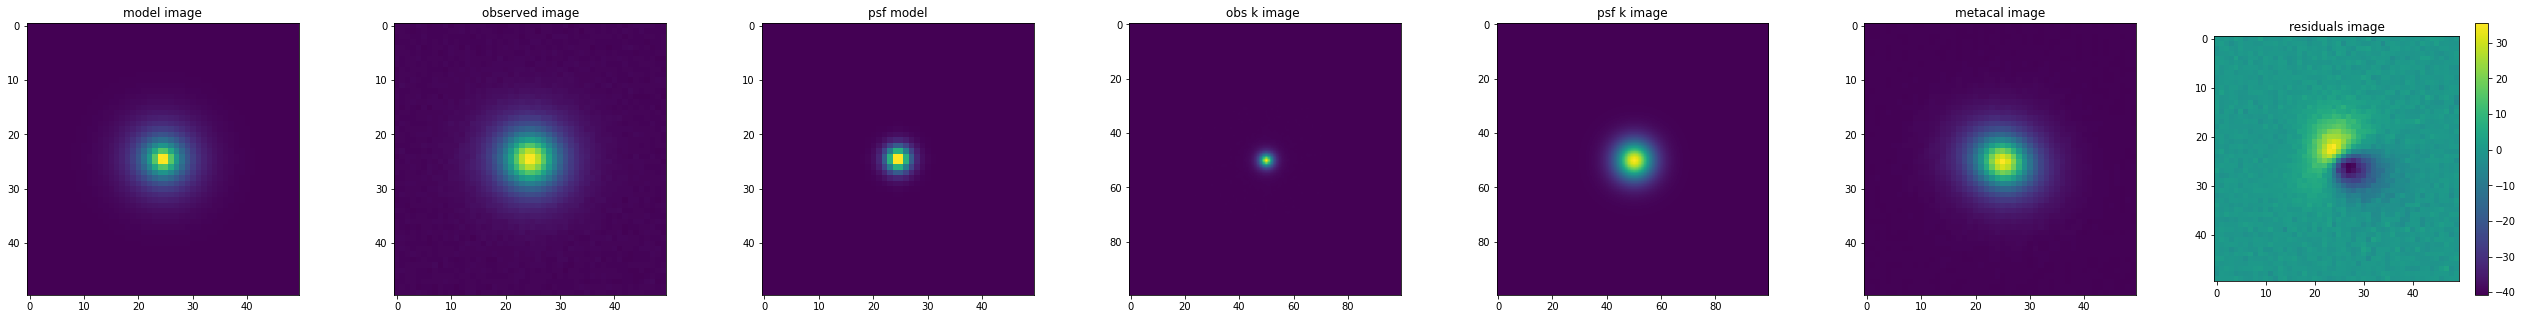

In [32]:
figure(figsize=[45,5])

subplot(171)
title('model image')
imshow(example['gal_model'])

subplot(172)
title('observed image')
imshow(example['obs_image'])

subplot(173)
title('psf model')
imshow(example['psf_image'])

subplot(174)
title('obs k image ')
imshow(obs_kimage.real)

subplot(175)
title('psf k image')
imshow(psf_kimage.real)

subplot(176)
title('metacal image')
imshow(metacal_img_test[0,...,0])

subplot(177)
title('residuals image')
imshow(example['obs_image'] - metacal_img_test[0,...,0] );colorbar()
plt.savefig('first_function_test.jpeg',bbox_inches='tight')

## Ellipticity Measurements

In [7]:
@tf.function
def get_ellipticity(img):
  img_size = len(img)
  nx = img_size
  ny = img_size
  XX=np.zeros((nx,ny))
  XY=np.zeros((nx,ny))
  YY=np.zeros((nx,ny))
  w = np.zeros((nx,ny))
  sigma=img_size/5

  for i in range(0,nx):
      x=0.5+i-(nx)/2.0
      for j in range(0,ny):
          y=0.5+j-(ny)/2.0
          XX[i,j]=x*x
          XY[i,j]=x*y
          YY[i,j]=y*y
          w[i,j]=np.exp(-((x) ** 2 + (y) ** 2) /
                                 (2 * sigma ** 2))
  img = tf.convert_to_tensor(img, dtype=tf.float32)
  norm = tf.reduce_sum(w*img)
  Q11 = tf.reduce_sum(w*img*YY)/norm
  Q12 = tf.reduce_sum(w*img*XY)/norm
  Q21 = Q12
  Q22 = tf.reduce_sum(w*img*XX)/norm

  q1 = Q11 - Q22
  q2 = 2*Q12

  T= Q11 + Q22  + 2*tf.sqrt(Q11*Q22 - Q12**2)
  return q1/T, q2/T

Simple test:

In [8]:
g_result, R =autometacal.metacal.get_metacal_response(example['obs_image'],
                    example['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,get_ellipticity)

In [9]:
# Apply inverse response matrix :-D
calibrated_g = tf.linalg.inv(R) @ tf.reshape(g_result,[2,1])

In [10]:
print("measured ellipticity  ", get_ellipticity(metacal_img_test[0,...,0]))
print("calibrated ellipticity", calibrated_g.numpy().squeeze())
print("true g1,g2            ",example['label'])

measured ellipticity   (<tf.Tensor: shape=(), dtype=float32, numpy=0.036870267>, <tf.Tensor: shape=(), dtype=float32, numpy=0.039565437>)
calibrated ellipticity [0.01238536 0.02336128]
true g1,g2             [0.01557902 0.01368018]


## Measuring ellipticities on a set of galaxies

In [11]:
g_result_list = []
R_list = []
for datapoint in datalist:
  obs_kimage = autometacal.datasets.gal_gen.recomplexify(datapoint['obs_kimage'])
  psf_kimage = autometacal.datasets.gal_gen.recomplexify(datapoint['psf_kimage'])
  psf_deconv = autometacal.datasets.gal_gen.recomplexify(datapoint['psf_deconv'])
  
  k_noise = autometacal.datasets.galaxies.gs_noise_generator(stamp_size=50,variance=5)
  g_result, R =autometacal.metacal.get_metacal_response(datapoint['obs_image'],
                    datapoint['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    k_noise,get_ellipticity)
  
  
  
  g_result_list.append(g_result)
  R_list.append(R)
  

Mean responsivity:

In [12]:
R_mean=np.nanmean(np.array(R_list),axis=0)
g_results_calib_mean = [ tf.linalg.inv(np.nanmean(np.array(R_list),axis=0)) @ tf.reshape(g_result,[2,1]) for g_result in g_result_list ]

## Plots

Get $g_1$ and $g_2$ for plots

In [13]:
g1_labels = np.array([datapoint['label'][0] for datapoint in datalist])
g1_results = np.array([g_result[0] for g_result in g_result_list ])
g1_calib_mean =np.array(g_results_calib_mean)[:,0]

In [14]:
g2_labels = np.array([datapoint['label'][1] for datapoint in datalist])
g2_results = np.array([g_result[1] for g_result in g_result_list ])
g2_calib_mean =np.array(g_results_calib_mean)[:,1]

Plot residuals with biases:

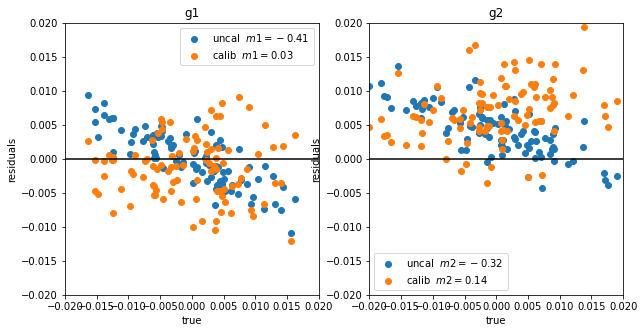

In [25]:
figure(figsize=(10,5))

y1_uncal = g1_results-g1_labels
y1_avcal = g1_calib_mean.reshape([-1])-g1_labels
m1_uncal, c1_uncal = linregress(g1_labels, y1_uncal)[:2] 
m1_avcal, c1_avcal = linregress(g1_labels, y1_avcal)[:2]

subplot(121)

scatter(g1_labels, y1_uncal, label=f'uncal  $m1 = {m1_uncal :.2f}$')
scatter(g1_labels, y1_avcal, label=f'calib  $m1 = {m1_avcal :.2f}$')
size_box = .02
plot([-size_box,size_box],[0,0],color='black')
xlim([-size_box,size_box])
ylim([-size_box,size_box])
legend()
xlabel('true')
ylabel('residuals')
title('g1')

y2_uncal = g2_results-g2_labels

y2_avcal = g2_calib_mean.reshape([-1])-g2_labels
m2_uncal, c2_uncal = linregress(g2_labels, y2_uncal)[:2] 

m2_avcal, c2_avcal = linregress(g2_labels, y2_avcal)[:2]

subplot(122)
scatter(g2_labels, y2_uncal, label=f'uncal  $m2 = {m2_uncal :.2f}$')
scatter(g2_labels, y2_avcal, label=f'calib  $m2 = {m2_avcal :.2f}$')
plot([-size_box,size_box],[0,0],color='black')
xlim([-size_box,size_box])
ylim([-size_box,size_box])
legend()
xlabel('true')
ylabel('residuals')
title('g2')
savefig('test_100_small_stamps_g12.jpeg',bbox_inches='tight')

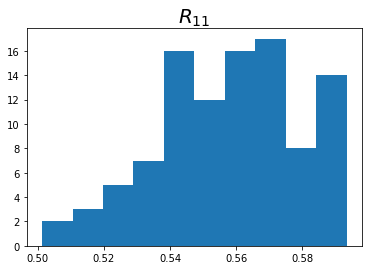

In [26]:
hist([R.numpy()[0,0] for R in R_list])
title('$R_{11}$',fontsize=20)
savefig('R_11_dist.png')

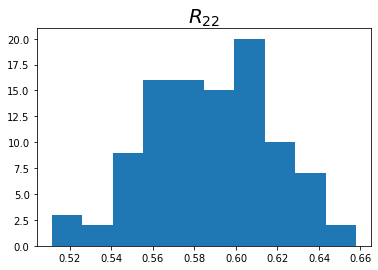

In [27]:
hist([R.numpy()[1,1] for R in R_list])
title('$R_{22}$',fontsize=20)
savefig('R_22_dist.png')

## Finite difference tests

In [18]:
def get_metacal_response_finite_diff_test(obs_image,
                                     psf_image,
                                     obs_kimage, 
                                     psf_kimage,
                                     psf_deconv,
                                     imnos,
                                     get_ellipticity,
                                     step=0.01):
  mcal1p =autometacal.metacal.generate_mcal_image(obs_image,
                    psf_image,
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,  [step,0])

  mcal1m =autometacal.metacal.generate_mcal_image(obs_image,
                    psf_image,
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,  [-step,0])
  mcal2p =autometacal.metacal.generate_mcal_image(obs_image,
                    psf_image,
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,  [0,step])
  mcal2m =autometacal.metacal.generate_mcal_image(obs_image,
                    psf_image,
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,  [0,-step])
  mcal0 =autometacal.metacal.generate_mcal_image(obs_image,
                    psf_image,
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,  [0,0])
  
  #measure ellipticities in counterfactuals
  g1p = get_ellipticity(mcal1p[0,...,0])
  g1m = get_ellipticity(mcal1m[0,...,0])
  g2p = get_ellipticity(mcal2p[0,...,0])
  g2m = get_ellipticity(mcal2m[0,...,0])
  
  #responsivity matrix
  d11 = (g1p[0] - g1m[0])/(2*step)
  d12 = (g2p[0] - g2m[0])/(2*step)
  d21 = (g1p[1] - g1m[1])/(2*step)
  d22 = (g2p[1] - g2m[1])/(2*step)
  
  #measure on unsheared
  g = get_ellipticity(mcal0[0,...,0])
  
  
  R = np.array([[d11,d12],[d21,d22]])
  
  return g, R
  

In [19]:
get_metacal_response_finite_diff_test(example['obs_image'],
                    example['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,get_ellipticity)

((<tf.Tensor: shape=(), dtype=float32, numpy=0.0030778511>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.023813488>),
 array([[ 5.6382680e-01, -1.3442477e-04],
        [ 3.2410026e-04,  5.2971983e-01]], dtype=float32))

In [20]:
autometacal.metacal.get_metacal_response(example['obs_image'],
                    example['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,get_ellipticity)

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00307785, 0.02381349], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.55991554,  0.10335779],
        [-0.06391445,  0.58423287]], dtype=float32)>)

In [39]:
g_auto_result_list = []
R_auto_list = []

g_finite_result_list = []
R_finite_list = []

for datapoint in datalist:
  obs_kimage = autometacal.datasets.gal_gen.recomplexify(datapoint['obs_kimage'])
  psf_kimage = autometacal.datasets.gal_gen.recomplexify(datapoint['psf_kimage'])
  psf_deconv = autometacal.datasets.gal_gen.recomplexify(datapoint['psf_deconv'])
  
  k_noise = autometacal.datasets.galaxies.gs_noise_generator(stamp_size=50,variance=5)
  g_auto_result, R_auto =autometacal.metacal.get_metacal_response(datapoint['obs_image'],
                    datapoint['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    k_noise,get_ellipticity)
  g_auto_result_list.append(g_auto_result)
  R_auto_list.append(R_auto)
  
  g_finite_result, R_finite =get_metacal_response_finite_diff_test(datapoint['obs_image'],
                    datapoint['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    k_noise,get_ellipticity)
  g_finite_result_list.append(g_finite_result)
  R_finite_list.append(R_finite)




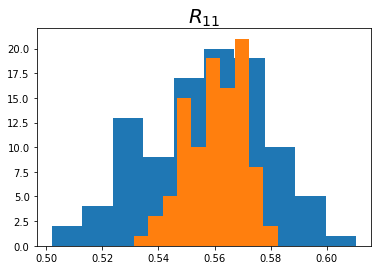

In [43]:
hist([R.numpy()[0,0] for R in R_auto_list])
hist([R[0,0] for R in R_finite_list])
title('$R_{11}$',fontsize=20)
savefig('R_11_dist.png')

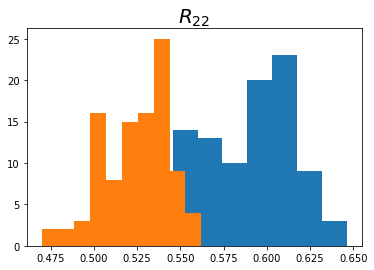

In [44]:
hist([R.numpy()[1,1] for R in R_auto_list])
hist([R[1,1] for R in R_finite_list])
title('$R_{22}$',fontsize=20)
savefig('R_22_dist.png')